In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import functools

In [2]:
poly_zero = np.poly1d([0])
poly_one = np.poly1d([1])
poly_x = np.poly1d([1, 0])
der_x_epsilon = 1e-8

def lagrange_li(xs: np.ndarray, n: int, i: int):
    global poly_x
    global poly_one
    x = poly_x
    def _li_item(i, j):
        return (x - xs[j]) / (xs[i] - xs[j])
    li_items = [_li_item(i, j) for j in range(n) if j != i]
    li = functools.reduce(np.polymul, li_items, poly_one)
    return li

def hermite_hi(xs: np.ndarray, n: int, i: int):
    global poly_x
    x = poly_x
    xi = xs[i]
    li = lagrange_li(xs, n, i)
    li_der = np.polyder(li)
    return (1 - (2 * (x - xi) * li_der(xi))) * (li ** 2)

def hermite_h_hat_i(xs: np.ndarray, n: int, i: int):
    global poly_x
    x = poly_x
    li = lagrange_li(xs, n, i)
    return (x - xs[i]) * (li ** 2)

def linear_slope(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return (y2 - y1) / (x2 - x1)

def estimate_y_ders_core(f: callable, epsilon: float, n: int, xs: np.ndarray, ys: np.ndarray):
    near_x_xs = np.array([x + epsilon for x in xs])
    near_x_ys = f(near_x_xs)
    return [linear_slope((xs[i], ys[i]), (near_x_xs[i], near_x_ys[i])) for i in range(n)]

def estimate_y_ders(f: callable, epsilon: float, n: int, xs: np.ndarray, ys: np.ndarray):
    y_ders = estimate_y_ders_core(f, epsilon, n - 1, xs[:-1], ys[:-1])
    y_ders = y_ders + estimate_y_ders_core(f, -epsilon, 1, np.array([xs[-1]]), np.array([ys[-1]]))
    return np.array(y_ders)

def weighted_ys_poly(xs: np.ndarray, ys: np.ndarray, n: int, f_weight: callable):
    global poly_zero
    lis = [f_weight(xs, n, i) * ys[i] for i in range(n)]
    p = functools.reduce(np.polyadd, lis, poly_zero)
    return p

def interpolation_lagrange_core(xs: np.ndarray, ys: np.ndarray, n: int):
    return weighted_ys_poly(xs, ys, n, lagrange_li)

def interpolation_lagrange_normal(f: callable, a: float, b: float, n: int):
    xs = np.linspace(a, b, n)
    ys = f(xs)
    return interpolation_lagrange_core(xs, ys, n), xs, ys

def interpolate_hermite_from_points(xs: np.ndarray, ys: np.ndarray, y_ders: np.ndarray, n: int):
    fh = weighted_ys_poly(xs, ys, n, hermite_hi)
    f_der_h_hats = weighted_ys_poly(xs, y_ders, n, hermite_h_hat_i)
    return fh + f_der_h_hats

def interpolate_piecewise_hermite(epsilon):
    def interpolate(f: callable, a: float, b: float, n: int):
        n = n // 2
        xs = np.linspace(a, b, n)
        ys = f(xs)
        y_ders = estimate_y_ders(f, epsilon, n, xs, ys)
        polies = [interpolate_hermite_from_points(xs[i:i+2], ys[i:i+2], y_ders[i:i+2], 2) for i in range(n - 1)]
        intervals_count = n - 1
        interval_len = (b - a) / intervals_count
        def estimate_x(x):
            if x < a or x > b:
                raise Exception("x={x} is not in the interpolation range")
            poly_index = int((x - a) / interval_len)
            poly_index = min(intervals_count - 1, poly_index)
            return polies[poly_index](x)
        def interpolation_func(xs):
            return np.array([estimate_x(x) for x in xs])
        return interpolation_func, xs, ys
    return interpolate

def interpolate_composite(epsilon):
    interpolate_hermite = interpolate_piecewise_hermite(epsilon)
    def interpolate(f: callable, a: float, b: float, n: int):
        if n < 1:
            raise Exception("Amount of sample points is 0 or less")
        elif n == 1:
            if a == b:
                x0 = a
            else:
                x0 = (a + b) / 2
            c = f(x0)
            return lambda xs: np.array([c for x in xs]), [x0], [c]
        elif n < 6:
            return interpolation_lagrange_normal(f, a, b, n)
        else:
            return interpolate_hermite(f, a, b, n)
    return interpolate

In [3]:
ns = [1, 10, 20, 50, 100]
interpolate_func = interpolate_composite(0.00001)

def plot_interpolation(func, f_interpolation, a, b, n):
    x = np.linspace(a, b, 200)
    y = func(x)
    p, x_sample, y_sample = f_interpolation(func, a, b, n)
    plt.plot(x, y, 'g')
    plt.plot(x_sample, y_sample, 'o')
    plt.plot(x, p(x), 'b')
    plt.show()
    #return p
    
def plot_interpolations(func, f_interpolation, ps):
    for a, b, n in ps:
        plot_interpolation(func, f_interpolation, a, b, n)

In [4]:
def func_m1(x):
    return 1 / (1 + 12 * (x ** 2))
#plot_interpolation(func0, interpolation_lagrange_normal, n)
#plot_interpolation(func0, interpolate_hermite(0.00001), n * 2)
#plot_interpolation(func0, interpolation_lagrange_with_dir, n * 2)
#plot_interpolations(func0, interpolate_func, ns)

In [5]:
def func1(x):
    return np.poly1d([5])(x)
#plot_interpolations(func1, interpolate_func, [(-1, 1, n) for n in ns])

In [6]:
def func_m2(x):
    return np.poly1d([-0.2, 4.1])(x)
#plot_interpolations(func2, interpolate_func, [(-1, 1, n) for n in ns])

In [7]:
def func2(x):
    return np.poly1d([1, -3, 5])(x)
#plot_interpolations(func3, interpolate_func, [(-2, 5, n) for n in ns])

In [8]:
def func_m3(x):
    return np.poly1d([2, 1, -3, 5])(x)
#plot_interpolations(func4, interpolate_func, [(-2.5, 2, n) for n in ns])

In [9]:
def func_m4(x):
    return np.poly1d([3, 2, 1, -3, 5])(x)
#plot_interpolations(func_m4, interpolate_func, [(-1, 1.2, n) for n in ns])

In [10]:
def func3(x):
    return np.sin(np.poly1d([1, 0, 0])(x))
#plot_interpolations(func3, interpolate_func, [(-2.5, 2.5, n) for n in ns])

In [11]:
def func4(x):
    return np.exp(np.poly1d([-2, 0, 0])(x))
#plot_interpolations(func4, interpolate_func, [(-2.5, 2.5, n) for n in ns])

In [12]:
def func5(x):
    return np.arctan(x)
#plot_interpolations(func5, interpolate_func, [(-2.5, 2.5, n) for n in ns])

In [13]:
def func6(x):
    return np.divide(np.sin(x), x)
#plot_interpolations(func6, interpolate_func, [(-4.1, -0.1, n) for n in ns])

In [14]:
def func_high_poly(d):
    a = np.random.randn(d)
    return np.poly1d(a)

#plot_interpolations(func_high_poly(300), interpolate_func, [(-4, 4, 301)])

In [15]:
def func7(x):
    return 1 / np.log(x)
#plot_interpolations(func7, interpolate_func, [(0.01, 0.99, n) for n in ns])
#plot_interpolations(func7, interpolate_func, [(1.0001, 7, n) for n in ns])

In [16]:
def func8(x):
    return np.exp(np.exp(x))
#plot_interpolations(func8, interpolate_func, [(-4, 4, n) for n in ns])

In [17]:
def func9(x):
    return np.log(np.log(x))
#plot_interpolations(func9, interpolate_func, [(1.0001, 7, n) for n in ns])

In [18]:
def func10(x):
    return np.sin(np.log(x))
#plot_interpolations(func10, interpolate_func, [(1e-9, 5, n) for n in ns])

In [19]:
def func11(x):
    return np.exp2(1 / (x ** 2)) * np.sin(1 / x)
#plot_interpolations(func11, interpolate_func, [(0.2, 6.25, n) for n in ns])
#p = plot_interpolation(func11, interpolate_func, 0.09, 10, 20)

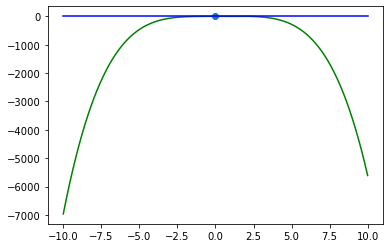

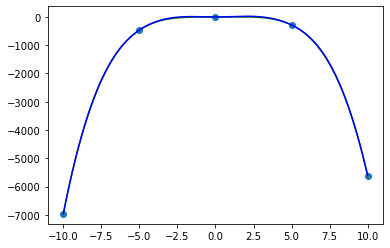

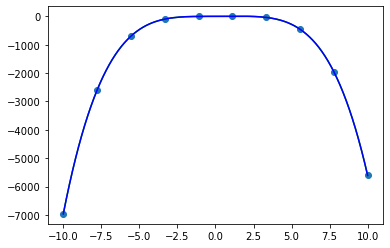

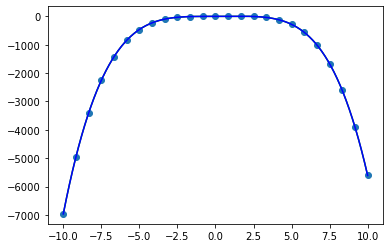

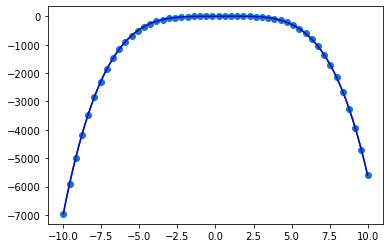

In [20]:
def func_m5():
    return np.poly1d([-0.63916896, 0.6616253, 1.0537745, 1.56807337, -1.36656823])
plot_interpolations(func_m5(), interpolate_func, [(-10, 10, n) for n in ns])

In [21]:
0.29727540158791266
_z = (300 + 1) // 2
print(_z)
_z = _z - 1
print(_z)
__z = ((10 - (-10)) / _z)
print(__z)
_y = ((0.29727540158791266) - (-10)) / __z
print(f"{_y}, {int(_y)}")

150
149
0.1342281879194631
76.71470174182994, 76
